## Final Project
##### UID: u0984549
##### Name: Marko Miholjcic

In [45]:
import getpass
import os
import torch
import numpy as np
from PIL import Image as im
from torch.utils.data import Dataset
import torchxrayvision as xrv
from torchvision import transforms
import torchvision
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
from sklearn.metrics import roc_curve, auc
import copy
import torchvision.models as models
import tarfile
import time
from packaging import version

%matplotlib inline

##### Check Torch library requirement #####
my_torch_version = torch.__version__
minimum_torch_version = '1.7'
if version.parse(my_torch_version) < version.parse(minimum_torch_version):
    print('Warning!!! Your Torch version %s does NOT meet the minimum requirement!\
            Please update your Torch library\n' %my_torch_version)

##### + Request GPU Usage:

In [46]:
##### Request a GPU #####
## This function locates an available gpu for usage. In addition, this function reserves a specificed
## memory space exclusively for your account. The memory reservation prevents the decrement in computational
## speed when other users try to allocate memory on the same gpu in the shared systems, i.e., CADE machines. 
## Note: If you use your own system which has a GPU with less than 4GB of memory, remember to change the 
## specified mimimum memory.
def define_gpu_to_use(minimum_memory_mb = 3500):    
    thres_memory = 600 #
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        
        if free_memory>minimum_memory_mb-thres_memory:
            gpu_to_use = i
            break
            
        print(free_memory)
            
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' + str(minimum_memory_mb) \
              + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-thres_memory)).cuda()
        x = torch.rand((1,1)).cuda()        
        del x
        
## Request a gpu and reserve the memory space
define_gpu_to_use()

GPU already assigned before: 0


## Data Loading
Data was imported into the notebook using the code below. It was placed into the scratch tmp folder.

In [48]:
os.chdir("/scratch/tmp/")

In [49]:
os.getcwd()

'/scratch/tmp'

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

In [50]:
data = xrv.datasets.COVID19_Dataset(imgpath = "/scratch/tmp/covid-chestxray-dataset/images/",
                                        csvpath = "/scratch/tmp/covid-chestxray-dataset/metadata.csv")

In [51]:
##### Preprocess Image #####
## This function is used to crop the largest 1:1 aspect ratio region of a given image.
## This is useful, especially for medical datasets, since many datasets have images
## with different aspect ratios and this is one way to standardize inputs' size.
class CropBiggestCenteredInscribedSquare(object):
    def __init__(self):
        pass

    def __call__(self, tensor):
        longer_side = min(tensor.size)
        horizontal_padding = (longer_side - tensor.size[0]) / 2
        vertical_padding = (longer_side - tensor.size[1]) / 2
        return tensor.crop(
            (
                -horizontal_padding,
                -vertical_padding,
                tensor.size[0] + horizontal_padding,
                tensor.size[1] + vertical_padding
            )
        )

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [52]:
##### Split a dataset for training, validatation, and testing #####
## This function splits a given dataset into 3 subsets of 60%-20%-20% for train-val-test, respectively.
## This function is used internally in the dataset classes below.
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.6)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.6):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [53]:
##### Compute the number parameters #####
## This function computes the number of learnable parameters in a Pytorch model
def count_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [54]:
class ChestXRayDataset(Dataset):
    ##### Initialize the class #####
    def __init__(self, path_dataset_folder, split = 'train', do_transform = False):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test'
        
        self.path_image_folder = '/scratch/tmp/covid-chestxray-dataset/images'
        
        self.do_transform = do_transform
        
        #used for short data
        #target_idx = list(range(2,4))+list(range(5,6))+list(range(8,13))+list(range(14,20))+list(range(21,25))
        
        ## This is the name of all possible labels in this dataset.
        ## The corresponding label of each sample is an array of 25/18 elements in which the elements are ordered
        ## in the same way as \"self.set_of_finding_labels\" and the value of each element represents the
        ## presence of that condition in the sample.
        self.pathologies = data.pathologies
        
        #used for short data
        #self.pathologies = np.array(data.pathologies)[target_idx]
        
        examples_to_use = []
        self.images = []
        self.targets = []
        
        for i in range(len(data)):
            examples_to_use.append(data[i]["idx"])
            self.images.append(data[i]["img"])
            self.targets.append(data[i]["lab"])
            #used for short dataset
            #self.targets.append(data[i]["lab"][target_idx])
            
        split_indices = get_split(examples_to_use, split)
        examples_to_use = [examples_to_use[i-1] for i in split_indices]
        self.images = [self.images[i - 1] for i in split_indices]
        self.targets = [self.targets[i-1] for i in split_indices]
        
        
        ## Define data augmentation transformations for the input images. In this exercise, we use the following
        ## transformations: square center cropping, resizing to 224x224 (to be similar as ImageNet dataset), 
        ## converting to tensor, normalizing per channel (i.e., R, G, and B) 
        ## with the average and standard deviation of images in the ImageNet dataset 
        if (self.do_transform):
            self.set_of_transforms = transforms.Compose(
            [CropBiggestCenteredInscribedSquare(),
                 transforms.Resize(224),
                 transforms.RandomAffine(0, (0,0.1)),
                 transforms.RandomAffine(0, (0.1,0)),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean=[0.5],
                                     std=[0.5])])
        else:
            self.set_of_transforms = transforms.Compose(
                [CropBiggestCenteredInscribedSquare(),
                 transforms.Resize(224),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean=[0.5],
                                     std=[0.5])])
        
    ##### Retrieve a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns an image and the corresponding label stored in Pytorch tensors     
    def __getitem__(self, index):
        curr_pil_image = im.fromarray(self.images[index][0,:,:])
        image_to_return = self.set_of_transforms(curr_pil_image)
                    
        return image_to_return, torch.FloatTensor(self.targets[index])
    
    ##### Get the length of the dataset #####
    def __len__(self):
        return len(self.images)
    
    ##### Access the name of conditions in the labels #####
    def get_labels_name(self):
        return self.pathologies

In [55]:
train_dataset = ChestXRayDataset(data, do_transform = True)
val_dataset = ChestXRayDataset(data, split = 'val')
test_dataset = ChestXRayDataset(data, split = 'test')

Percentage of positive examples in each class in the training set: 

Aspergillosis: 0.31%,
Aspiration: 0.31%,
Bacterial: 8.72%,
COVID-19: 60.12%,
Chlamydophila: 0.00%,
Fungal: 4.05%,
H1N1: 0.31%,
Herpes : 0.62%,
Influenza: 1.25%,
Klebsiella: 1.25%,
Legionella: 1.87%,
Lipoid: 1.25%,
MERS-CoV: 1.56%,
MRSA: 0.31%,
Mycoplasma: 1.25%,
No Finding: 4.05%,
Nocardia: 0.93%,
Pneumocystis: 3.74%,
Pneumonia: 93.46%,
SARS: 3.43%,
Staphylococcus: 0.31%,
Streptococcus: 2.80%,
Tuberculosis: 2.49%,
Varicella: 0.93%,
Viral: 67.91%


Showing one example from the dataset:

Aspergillosis: 0.0,
Aspiration: 0.0,
Bacterial: 0.0,
COVID-19: 0.0,
Chlamydophila: 0.0,
Fungal: 0.0,
H1N1: 0.0,
Herpes : 0.0,
Influenza: 0.0,
Klebsiella: 0.0,
Legionella: 0.0,
Lipoid: 0.0,
MERS-CoV: 0.0,
MRSA: 0.0,
Mycoplasma: 0.0,
No Finding: 0.0,
Nocardia: 0.0,
Pneumocystis: 0.0,
Pneumonia: 1.0,
SARS: 0.0,
Staphylococcus: 0.0,
Streptococcus: 0.0,
Tuberculosis: 0.0,
Varicella: 0.0,
Viral: 0.0


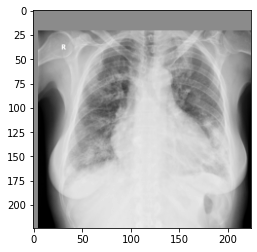

In [56]:
##### Helper function for display text below #####
def join_str_array_to_labels(str_array,labels):
    return ','.join(['\n{}: {}'.format(labels[index_element], str_array_element) 
                for index_element, str_array_element in enumerate(str_array)])

## Show the statistics of training set
frequencies = np.sum(train_dataset.targets, axis = 0)/len(train_dataset)
text_frequencies = ['{:.2f}%'.format(frequency*100) for frequency in frequencies]                    
print('Percentage of positive examples in each class in the training set: ')
print(join_str_array_to_labels(text_frequencies, train_dataset.get_labels_name()))

## Plot a sample from the training set
print('\n\nShowing one example from the dataset:')
plt.imshow(train_dataset[1][0].cpu().numpy()[0,:,:], cmap = 'gray')
print(join_str_array_to_labels(train_dataset[1][1],train_dataset.get_labels_name()))

In [57]:
weights = np.sum(train_dataset.targets, axis = 0)
loss_function = torch.nn.MultiLabelSoftMarginLoss()

In [58]:
##### Compute accuracy for MNIST dataset #####
def get_accuracy(model, data_loader):
    ## Toggle model to eval mode
    model.eval()
    
    ## Iterate through the dataset and perform inference for each sample.
    ## Store inference results and target labels for AUC computation 
    with torch.no_grad():
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores
        acc = 0.0
        data_length = 0.0
        
        acc_list = []
        for image, target in data_loader:
            image = image.cuda(); 
            target = target.cuda()
            probs = model(image)
            preds = torch.sigmoid(probs)
          
            ## change to 18 for shorter label dataset
            pred_prob = (preds > 0.5) * torch.from_numpy(np.ones([preds.size()[0],25])).cuda()
            
            pred_prob = pred_prob.cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            
            for i in range(len(pred_prob)):
                correct = 0
                total_length = 0
                for j in range(len(pred_prob[i])):
                    if (pred_prob[i][j] - target[i][j] == 0):
                        correct = correct + 1
                    total_length = total_length + 1
                if (correct - total_length == 0):
                    acc = acc + 1
                data_length = data_length + 1
                
    return acc/data_length  

In [59]:
##### Calculate AUC metric #####
## This function compute AUC from the given input arrays i.e., predicted value and ground truth arrays
def auroc(logits_predicted, target):
    fpr, tpr, _ = roc_curve(target, logits_predicted)
    return auc(fpr, tpr)

##### Compute AUC of a given dataset #####
## This function takes a model and Pytorch data loader as input. 
## The given model is used to predict the expected label for each sample in the Pytorch data loader. The 
## model output for each sample is an array with 25 elements corresponding with 25 conditions in the 
## dataset. Then, the AUC is computed for each condition.
def get_score_model(model, data_loader):
    ## Toggle model to eval mode
    model.eval()
    
    ## Iterate through the dataset and perform inference for each sample.
    ## Store inference results and target labels for AUC computation 
    with torch.no_grad():
        
        logits_predicted = np.zeros([0, 25]) #change to 18 for shorter labels dataset
        targets = np.zeros([0, 25])          #change to 18 for shorter labels dataset
        
        ## Iterate through the dataset and perform inference for each sample.
        ## Store inference results and target labels for AUC computation  
        for image, target in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy())\
                                              , axis = 0)
            targets = np.concatenate((targets, target.cpu().detach().numpy()), axis = 0)
            
    ## Return a list of auc values in which each value corresponds to one of the 18/25 labels
    return [auroc(logits_predicted[i,:], targets[i,:]) for i in range(25)]

In [60]:
##### Set-up Pytorch dataloader #####
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

In [ ]:
class TwoConvBlock(torch.nn.Module):
  
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_maxpool = torch.nn.Sequential(
                                    torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1,
                                                    padding = 1, bias = True), 
                                    torch.nn.ReLU(inplace = True),
                                    torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1,
                                                    padding = 1, bias = True),
                                    torch.nn.ReLU(inplace = True),
                                    torch.nn.MaxPool2d(kernel_size = 2, stride = 2))

    def forward(self, x):
        return self.conv_maxpool(x)

class FourConvBlock(torch.nn.Module):
  
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.four_conv_maxpool = torch.nn.Sequential(
                                    torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1,
                                            padding = 1,bias = True), 
                                    torch.nn.ReLU(inplace = True),
                                    torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1,
                                            padding = 1,bias = True),
                                    torch.nn.ReLU(inplace = True),
                                    torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1,
                                            padding = 1, bias = True),
                                    torch.nn.ReLU(inplace = True),
                                    torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, 
                                            padding = 1, bias = True),
                                    torch.nn.ReLU(inplace = True),
                            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
  
    def forward(self, x):
        return self.four_conv_maxpool(x)

class MyVGG(torch.nn.Module):
    def __init__ (self):
        super(MyVGG, self).__init__()
        self.conv_layers1 = TwoConvBlock(1,32)
        self.conv_layers2 = TwoConvBlock(32,64)
        self.conv_layers3 = FourConvBlock(64,128)
        self.conv_layers4 = FourConvBlock(128,256)
        self.conv_layers5 = FourConvBlock(256,256)
        
        self.seq = torch.nn.Sequential(
                    torch.nn.AdaptiveAvgPool2d(output_size = (7,7)),
                    torch.nn.Flatten(),
                    torch.nn.Linear(in_features = 12544, out_features = 2048, bias = True),
                    torch.nn.ReLU(inplace = True),
                    torch.nn.Dropout(p=0.5, inplace = False),
                    torch.nn.Linear(in_features = 2048, out_features = 2048, bias = True),
                    torch.nn.ReLU(inplace = True),
                    torch.nn.Dropout(p=0.5, inplace = False),
                    torch.nn.Linear(in_features = 2048, out_features = 25, bias = True),
                    )
    
    def forward(self, x):
        layer1 = self.conv_layers1(x)
        layer2 = self.conv_layers2(layer1)
        layer3 = self.conv_layers3(layer2)
        layer4 = self.conv_layers4(layer3)
        layer5 = self.conv_layers5(layer4)
        
        out = self.seq(layer5)
        return out

model_1 = MyVGG()
model_1

In [ ]:
count_number_parameters(model_1)

Ep 0: Train Mean AUC = 0.91076;
Val Mean AUC = 0.98061
Ep 0: Train Loss = 0.26654; Train Acc = 0.59190
Val Acc = 0.64486
Ep 1: Train Mean AUC = 0.93158;
Val Mean AUC = 0.94455
Ep 1: Train Loss = 0.17811; Train Acc = 0.07477
Val Acc = 0.05607
Ep 2: Train Mean AUC = 0.93932;
Val Mean AUC = 0.93128
Ep 2: Train Loss = 0.17194; Train Acc = 0.04984
Val Acc = 0.04673
Ep 3: Train Mean AUC = 0.95076;
Val Mean AUC = 0.95955
Ep 3: Train Loss = 0.16177; Train Acc = 0.58879
Val Acc = 0.66355
Ep 4: Train Mean AUC = 0.93535;
Val Mean AUC = 0.98474
Ep 4: Train Loss = 0.15629; Train Acc = 0.45171
Val Acc = 0.41121
Ep 5: Train Mean AUC = 0.94970;
Val Mean AUC = 0.97017
Ep 5: Train Loss = 0.16429; Train Acc = 0.56386
Val Acc = 0.60748
Ep 6: Train Mean AUC = 0.93467;
Val Mean AUC = 0.97152
Ep 6: Train Loss = 0.15527; Train Acc = 0.50467
Val Acc = 0.58879
Ep 7: Train Mean AUC = 0.97357;
Val Mean AUC = 0.95879
Ep 7: Train Loss = 0.15421; Train Acc = 0.48287
Val Acc = 0.41121
Ep 8: Train Mean AUC = 0.93576;


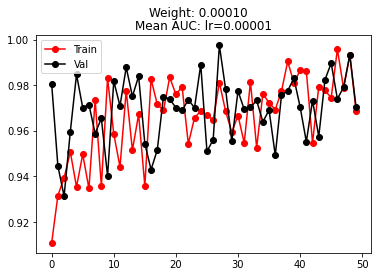

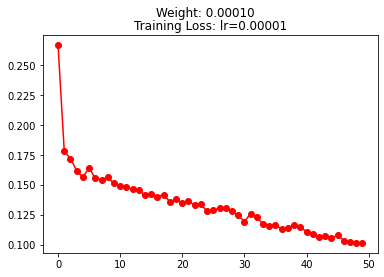

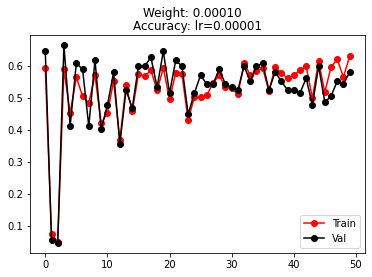

In [62]:
#lr = [10**-2, 10**-3, 10**-4, 10**-5]
#weight_decay = [10**0, 10**-2, 10**-4]

lr = [0.00001]
weight_decay = [0.0001]

df = pd.DataFrame({'Learning Rate':[], 
                  'Epoch':[],
                  'Mean AUC':[]})

for i in range(len(lr)):
    for j in range(len(weight_decay)):
    
        torch.cuda.empty_cache()
    
        model = model_1
        model = model.cuda()
    
        optimizer = torch.optim.Adam(model.parameters(), lr=lr[i], weight_decay=weight_decay[j])

        train_loss_list = []
        mean_train_auc_list = []
        mean_val_auc_list = []
        mean_best_auc = 1e-9
    
        train_acc_list = [] 
        val_acc_list = []
        best_acc = 1e-9

        num_epochs = 50

        ## Loop through number of epochs
        for ep in range(num_epochs): 

            running_loss = 0.0
            ## Put model on train mode
            model.train()
    
            ## Loop through batches of samples
            for imgs, labels in train_loader:
        
            ## Zero the gradients
                optimizer.zero_grad()
        
                ## Send input and label to GPU
                with torch.set_grad_enabled(True):
                    imgs = imgs.cuda()
                    labels = labels.cuda()            
                    outputs = model(imgs)

                    ## Compute the loss
                    loss = loss_function(outputs, labels)

                    ## Perform backward pass
                    loss.backward()

                    ## Update parameters
                    optimizer.step()
                running_loss += (loss.item()*imgs.size(0))
    
            curr_ep_loss = running_loss / len(train_loader.dataset)
            curr_train_auc = get_score_model(model, train_loader)
            mean_train_auc = np.mean(curr_train_auc)
            curr_val_auc = get_score_model(model, val_loader)
            mean_val_auc = np.mean(curr_val_auc)

            print('Ep {:d}: Train Mean AUC = {:.5f};'.format(ep,mean_train_auc))
            print('Val Mean AUC = {:.5f}'.format(mean_val_auc))
            train_loss_list.append(curr_ep_loss)
            mean_train_auc_list.append(mean_train_auc); 
            mean_val_auc_list.append(mean_val_auc)
           
            ## Evaluate the current stage of the model on training set and validation set
            curr_train_acc = get_accuracy(model, train_loader)
            curr_val_acc = get_accuracy(model, val_loader)
            print('Ep {:d}: Train Loss = {:.5f}; Train Acc = {:.5f}'.format(ep,curr_ep_loss,curr_train_acc))
            print('Val Acc = {:.5f}'.format(curr_val_acc))
            train_acc_list.append(curr_train_acc); 
            val_acc_list.append(curr_val_acc)
        
            data = [{'Learning Rate':lr[i], 'Weight Decay': weight_decay[j], 'Epoch':ep, 'Mean AUC':mean_val_auc,
                    '%Acc':curr_val_acc}]
            df = df.append(data, ignore_index=True, sort = False)
    
            ## Save the model 
            if mean_val_auc > mean_best_auc and curr_val_acc >= best_acc:
                best_acc = curr_val_acc
                mean_best_auc = mean_val_auc
                best_model_dict = copy.deepcopy(model.state_dict())
                torch.save(best_model_dict, './best_model_1.pt')
                best_model = model

        ## Plot training statistics
        plt.figure()
        plt.plot(mean_train_auc_list,'ro-',mean_val_auc_list,'ko-')
        plt.legend(['Train','Val'])
        plt.title('Mean AUC: lr=%1.5f' %lr[i])
        plt.suptitle("Weight: %1.5f" %weight_decay[j])

        plt.figure()
        plt.title('Training Loss: lr=%1.5f' %lr[i])
        plt.plot(train_loss_list,'ro-')
        plt.suptitle("Weight: %1.5f" %weight_decay[j])
    
        plt.figure()
        plt.plot(train_acc_list,'ro-',val_acc_list,'ko-')
        plt.legend(['Train','Val'])
        plt.title('Accuracy: lr=%1.5f' %lr[i])
        plt.suptitle("Weight: %1.5f" %weight_decay[j])

In [63]:
test_auc = get_score_model(best_model, test_loader)
mean_test_auc = np.mean(test_auc)
curr_test_acc = get_accuracy(best_model, test_loader)
print('Test Acc = {:.5f}'.format(curr_test_acc))
print('Mean AUC: {:.3f};'.format(mean_test_auc))
### Your code ends here

Test Acc = 0.57009
Mean AUC: 0.974;


## Analyzing Results

In [7]:
myVGGAdam = pd.read_csv("MyVGGAdam.csv")
myVGGAdamFilter = myVGGAdam[myVGGAdam["Mean AUC"] > 0.98]
myVGGAdamFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
44,44,0.00100,4.0,0.984848,0.0100,0.663551
52,52,0.00100,2.0,0.988485,0.0001,0.663551
76,76,0.00010,6.0,0.981212,0.0100,0.663551
83,83,0.00010,3.0,0.988485,0.0001,0.663551
103,103,0.00001,3.0,0.980606,0.0100,0.663551
107,107,0.00001,7.0,0.981212,0.0100,0.663551
116,116,0.00001,6.0,0.983030,0.0001,0.663551


In [12]:
myVGGAdamFilter = myVGGAdam[myVGGAdam["Mean AUC"] < 0.90]
myVGGAdamFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
0,0,0.010,0.0,0.820606,1.0000,0.093458
1,1,0.010,1.0,0.896364,1.0000,0.093458
2,2,0.010,2.0,0.882984,1.0000,0.663551
4,4,0.010,4.0,0.892596,1.0000,0.663551
6,6,0.010,6.0,0.818656,1.0000,0.093458
9,9,0.010,9.0,0.889091,1.0000,0.663551
10,10,0.010,0.0,0.884848,0.0100,0.000000
28,28,0.010,8.0,0.880758,0.0001,0.663551
38,38,0.001,8.0,0.873050,1.0000,0.000000


In [13]:
myVGGSGD = pd.read_csv("MyVGG_SGD.csv")
myVGGSGDFilter = myVGGSGD[myVGGSGD["Mean AUC"] > 0.98]
myVGGSGDFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
42,42,0.01000,12.0,0.989091,0.0001,0.663551
107,107,0.00010,2.0,0.986061,0.0100,0.663551
127,127,0.00010,7.0,0.983636,0.0001,0.663551
131,131,0.00010,11.0,0.983636,0.0001,0.663551
137,137,0.00001,2.0,0.989091,1.0000,0.663551
143,143,0.00001,8.0,0.980738,1.0000,0.663551
153,153,0.00001,3.0,0.988636,0.0100,0.663551
157,157,0.00001,7.0,0.983182,0.0100,0.663551
172,172,0.00001,7.0,0.991515,0.0001,0.663551
175,175,0.00001,10.0,0.981818,0.0001,0.663551


In [18]:
myVGGSGDFilter = myVGGSGD[myVGGSGD["Mean AUC"] < 0.94]
myVGGSGDFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
2,2,0.01000,2.0,0.930909,1.0000,0.663551
3,3,0.01000,3.0,0.927490,1.0000,0.663551
7,7,0.01000,7.0,0.933155,1.0000,0.663551
9,9,0.01000,9.0,0.939447,1.0000,0.663551
13,13,0.01000,13.0,0.919545,1.0000,0.663551
14,14,0.01000,14.0,0.937424,1.0000,0.663551
18,18,0.01000,3.0,0.937523,0.0100,0.663551
37,37,0.01000,7.0,0.936364,0.0001,0.663551
44,44,0.01000,14.0,0.935303,0.0001,0.663551
70,70,0.00100,10.0,0.932220,0.0100,0.663551


In [19]:
myVGGAdam = pd.read_csv("MyVGGAdamAug.csv")
myVGGAdamFilter = myVGGAdam[myVGGAdam["Mean AUC"] > 0.98]
myVGGAdamFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
9,9,0.01000,9.0,0.981818,1.0000,0.663551
43,43,0.00100,3.0,0.985455,0.0100,0.000000
56,56,0.00100,6.0,0.982424,0.0001,0.663551
70,70,0.00010,0.0,0.984848,0.0100,0.663551
93,93,0.00001,3.0,0.986667,1.0000,0.663551
97,97,0.00001,7.0,0.990303,1.0000,0.663551
117,117,0.00001,7.0,0.984717,0.0001,0.663551
119,119,0.00001,9.0,0.980817,0.0001,0.663551


In [20]:
myVGGAdam = pd.read_csv("MyVGGAdamAug.csv")
myVGGAdamFilter = myVGGAdam[myVGGAdam["Mean AUC"] < 0.90]
myVGGAdamFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
3,3,0.01,3.0,0.892095,1.00,0.663551
4,4,0.01,4.0,0.880007,1.00,0.663551
12,12,0.01,2.0,0.888636,0.01,0.000000


In [21]:
myVGGSGD = pd.read_csv("MyVGG_SGDAug.csv")
myVGGSGDFilter = myVGGSGD[myVGGSGD["Mean AUC"] > 0.98]
myVGGSGDFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
8,8,0.01000,3.0,0.982424,0.0100,0.663551
13,13,0.01000,3.0,0.983636,0.0001,0.663551
23,23,0.00100,3.0,0.980606,0.0100,0.663551
46,46,0.00001,1.0,0.983030,1.0000,0.663551
47,47,0.00001,2.0,0.992121,1.0000,0.663551
49,49,0.00001,4.0,0.985455,1.0000,0.663551
58,58,0.00001,3.0,0.985455,0.0001,0.663551
59,59,0.00001,4.0,0.983636,0.0001,0.663551


In [27]:
myVGGSGD = pd.read_csv("MyVGG_SGDAug.csv")
myVGGSGDFilter = myVGGSGD[myVGGSGD["Mean AUC"] < 0.94]
myVGGSGDFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
39,39,0.00010,4.0,0.935250,0.01,0.663551
50,50,0.00001,0.0,0.933333,0.01,0.663551
52,52,0.00001,2.0,0.936917,0.01,0.663551


In [30]:
myVGGAdam = pd.read_csv("MyVGGAdamAugShort.csv")
myVGGAdamFilter = myVGGAdam[myVGGAdam["Mean AUC"] > 0.98]
myVGGAdamFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
15,15,0.01000,5.0,0.991358,0.0100,0.000000
25,25,0.01000,5.0,0.982948,0.0001,0.663551
30,30,0.00100,0.0,0.986420,1.0000,0.663551
39,39,0.00100,9.0,0.984645,1.0000,0.663551
82,82,0.00010,2.0,0.988889,0.0001,0.663551
84,84,0.00010,4.0,1.000000,0.0001,0.663551
91,91,0.00001,1.0,0.992824,1.0000,0.663551
97,97,0.00001,7.0,0.988889,1.0000,0.663551
98,98,0.00001,8.0,0.992593,1.0000,0.663551
118,118,0.00001,8.0,0.980247,0.0001,0.663551


In [33]:
myVGGSGD = pd.read_csv("MyVGG_SGDAugShort.csv")
myVGGSGDFilter = myVGGSGD[myVGGSGD["Mean AUC"] > 0.98]
myVGGSGDFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
8,8,0.01000,3.0,0.982424,0.0100,0.663551
13,13,0.01000,3.0,0.983636,0.0001,0.663551
23,23,0.00100,3.0,0.980606,0.0100,0.663551
46,46,0.00001,1.0,0.983030,1.0000,0.663551
47,47,0.00001,2.0,0.992121,1.0000,0.663551
49,49,0.00001,4.0,0.985455,1.0000,0.663551
58,58,0.00001,3.0,0.985455,0.0001,0.663551
59,59,0.00001,4.0,0.983636,0.0001,0.663551


In [36]:
myResAdam = pd.read_csv("ResidualAdam.csv")
myResAdamFilter = myResAdam[myResAdam["Mean AUC"] > 0.98]
myResAdamFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
23,23,0.01000,3.0,0.980580,0.0001,0.654206
63,63,0.00010,3.0,0.988485,1.0000,0.644860
98,98,0.00001,8.0,0.980606,1.0000,0.654206
99,99,0.00001,9.0,0.983333,1.0000,0.663551
115,115,0.00001,5.0,0.981212,0.0001,0.663551
117,117,0.00001,7.0,0.987273,0.0001,0.654206
119,119,0.00001,9.0,0.983030,0.0001,0.663551


In [41]:
myResAdam = pd.read_csv("ResidualSGD.csv")
myResAdamFilter = myResAdam[myResAdam["Mean AUC"] > 0.98]
myResAdamFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
18,18,0.01000,8.0,0.982635,0.0100,0.000000
24,24,0.01000,4.0,0.982424,0.0001,0.663551
26,26,0.01000,6.0,0.987879,0.0001,0.663551
30,30,0.00100,0.0,0.983030,1.0000,0.663551
36,36,0.00100,6.0,0.984242,1.0000,0.663551
57,57,0.00100,7.0,0.980606,0.0001,0.663551
75,75,0.00010,5.0,0.984848,0.0100,0.663551
91,91,0.00001,1.0,0.992121,1.0000,0.663551
96,96,0.00001,6.0,0.983636,1.0000,0.663551
111,111,0.00001,1.0,0.985455,0.0001,0.663551


In [43]:
myMNISTAdam = pd.read_csv("MNISTAdam.csv")
myMNISTAdamFilter = myMNISTAdam[myMNISTAdam["Mean AUC"] > 0.98]
myMNISTAdamFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
17,17,0.01000,7.0,0.984848,0.0100,0.663551
23,23,0.01000,3.0,0.986667,0.0001,0.663551
38,38,0.00100,8.0,0.987484,1.0000,0.093458
54,54,0.00100,4.0,0.980152,0.0001,0.663551
58,58,0.00100,8.0,0.980606,0.0001,0.663551
60,60,0.00010,0.0,0.981818,1.0000,0.663551
68,68,0.00010,8.0,0.981818,1.0000,0.663551
85,85,0.00010,5.0,0.987879,0.0001,0.663551
92,92,0.00001,2.0,0.980606,1.0000,0.663551
93,93,0.00001,3.0,0.989091,1.0000,0.663551


In [44]:
myMNISTSGD = pd.read_csv("MNIST_SGD.csv")
myMNISTSGDFilter = myMNISTAdam[myMNISTAdam["Mean AUC"] > 0.98]
myMNISTSGDFilter

,Unnamed: 0,Learning Rate,Epoch,Mean AUC,Weight Decay,%Acc
17,17,0.01000,7.0,0.984848,0.0100,0.663551
23,23,0.01000,3.0,0.986667,0.0001,0.663551
38,38,0.00100,8.0,0.987484,1.0000,0.093458
54,54,0.00100,4.0,0.980152,0.0001,0.663551
58,58,0.00100,8.0,0.980606,0.0001,0.663551
60,60,0.00010,0.0,0.981818,1.0000,0.663551
68,68,0.00010,8.0,0.981818,1.0000,0.663551
85,85,0.00010,5.0,0.987879,0.0001,0.663551
92,92,0.00001,2.0,0.980606,1.0000,0.663551
93,93,0.00001,3.0,0.989091,1.0000,0.663551


## Testing SGD

In [ ]:
#lr = [10**-2, 10**-3, 10**-4, 10**-5]
#weight_decay = [10**0, 10**-2, 10**-4]

lr = [0.00001]
weight_decay = [1]

df2 = pd.DataFrame({'Learning Rate':[], 
                  'Epoch':[],
                  'Mean AUC':[]})

for i in range(len(lr)):
    for j in range(len(weight_decay)):
    
        torch.cuda.empty_cache()
    
        model = model_1
        model = model.cuda()
    
        optimizer =  torch.optim.SGD(model.parameters(), lr=lr[i], weight_decay = weight_decay[j], momentum=0.9)

        train_loss_list = []
        mean_train_auc_list = []
        mean_val_auc_list = []
        mean_best_auc = 1e-9
    
        train_acc_list = [] 
        val_acc_list = []
        best_acc = 1e-9

        num_epochs = 10

        ## Loop through number of epochs
        for ep in range(num_epochs): 

            running_loss = 0.0
            ## Put model on train mode
            model.train()
    
            ## Loop through batches of samples
            for imgs, labels in train_loader:
        
            ## Zero the gradients
                optimizer.zero_grad()
        
                ## Send input and label to GPU
                with torch.set_grad_enabled(True):
                    imgs = imgs.cuda()
                    labels = labels.cuda()            
                    outputs = model(imgs)

                    ## Compute the loss
                    loss = loss_function(outputs, labels)

                    ## Perform backward pass
                    loss.backward()

                    ## Update parameters
                    optimizer.step()
                running_loss += (loss.item()*imgs.size(0))
    
            curr_ep_loss = running_loss / len(train_loader.dataset)
            curr_train_auc = get_score_model(model, train_loader)
            mean_train_auc = np.mean(curr_train_auc)
            curr_val_auc = get_score_model(model, val_loader)
            mean_val_auc = np.mean(curr_val_auc)

            print('Ep {:d}: Train Mean AUC = {:.5f};'.format(ep,mean_train_auc))
            print('Val Mean AUC = {:.5f}'.format(mean_val_auc))
            train_loss_list.append(curr_ep_loss)
            mean_train_auc_list.append(mean_train_auc); 
            mean_val_auc_list.append(mean_val_auc)
           
            ## Evaluate the current stage of the model on training set and validation set
            curr_train_acc = get_accuracy(model, train_loader)
            curr_val_acc = get_accuracy(model, val_loader)
            print('Ep {:d}: Train Loss = {:.5f}; Train Acc = {:.5f}'.format(ep,curr_ep_loss,curr_train_acc))
            print('Val Acc = {:.5f}'.format(curr_val_acc))
            train_acc_list.append(curr_train_acc); 
            val_acc_list.append(curr_val_acc)
        
            data = [{'Learning Rate':lr[i], 'Weight Decay': weight_decay[j], 'Epoch':ep, 'Mean AUC':mean_val_auc,
                    '%Acc':curr_val_acc}]
            df2 = df2.append(data, ignore_index=True, sort = False)
    
            ## Save the model 
            if mean_val_auc > mean_best_auc and curr_val_acc >= best_acc:
                best_acc = curr_val_acc
                mean_best_auc = mean_val_auc
                best_model_dict = copy.deepcopy(model.state_dict())
                torch.save(best_model_dict, './best_model_1.pt')
                best_model = model

        ## Plot training statistics
        plt.figure()
        plt.plot(mean_train_auc_list,'ro-',mean_val_auc_list,'ko-')
        plt.legend(['Train','Val'])
        plt.title('Mean AUC: lr=%1.5f' %lr[i])
        plt.suptitle("Weight: %1.5f" %weight_decay[j])

        plt.figure()
        plt.title('Training Loss: lr=%1.5f' %lr[i])
        plt.plot(train_loss_list,'ro-')
        plt.suptitle("Weight: %1.5f" %weight_decay[j])
    
        plt.figure()
        plt.plot(train_acc_list,'ro-',val_acc_list,'ko-')
        plt.legend(['Train','Val'])
        plt.title('Accuracy: lr=%1.5f' %lr[i])
        plt.suptitle("Weight: %1.5f" %weight_decay[j])

In [ ]:
original_model = torchvision.models.vgg19(pretrained = True)

class ModifyVGG19(torch.nn.Module):
    def __init__(self):
        super(ModifyVGG19, self).__init__()
        
        self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(1, 3, kernel_size = 1))
        
        original_model.classifier._modules['6'] = torch.nn.Linear(4096,25)
        
        self.model = original_model
        
        
    def forward(self, x):
        layer = self.conv_layer(x)
        out = self.model(layer)
        return out

model_1 = ModifyVGG19()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
##### Implement a CNN, named model_ex1, with the architecture specified above #####
### Your code starts here ###
model_1 = torch.nn.Sequential(
                torch.nn.ZeroPad2d((2,2,2,2)),
                torch.nn.Conv2d(1,6,kernel_size = 5, stride = 1, padding = 0, bias = True),
                torch.nn.ReLU(inplace = True),
                torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                torch.nn.Conv2d(6,16,kernel_size = 5, stride = 1, padding = 0, bias = True),
                torch.nn.ReLU(inplace = True),
                torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
                torch.nn.Conv2d(16,120, kernel_size = 5, stride = 1, padding = 0, bias = True),
                torch.nn.ReLU(inplace = True),
                torch.nn.AdaptiveAvgPool2d(output_size = (1,1)),
                torch.nn.Flatten(),
                torch.nn.Linear(in_features = 120, out_features = 84, bias = True),
                torch.nn.Dropout(p = 0.5),
                torch.nn.ReLU(inplace = True),
                torch.nn.Linear(in_features = 84, out_features = 25, bias = True)
)
### Your code ends here ###

In [61]:
class FourConvBlockWResidual(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.four_conv_maxpool = torch.nn.Sequential(
                                    torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, 
                                            padding = 1,bias = True), 
                                    torch.nn.ReLU(inplace = True),
                                    torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, 
                                            padding = 1,bias = True),
                                    torch.nn.ReLU(inplace = True),
                                    torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, 
                                            padding = 1, bias = True),
                                    torch.nn.ReLU(inplace = True),
                                    torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1,
                                            padding = 1, bias = True))
    def forward(self, x):
        return self.four_conv_maxpool(x)
    
class TwoConvBlockWResidual(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.two_conv_maxpool = torch.nn.Sequential(
                                    torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, 
                                            padding = 1,bias = True), 
                                    torch.nn.ReLU(inplace = True),
                                    torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, 
                                            padding = 1,bias = True))
    def forward(self, x):
        return self.two_conv_maxpool(x)
    
class ChannelsLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = torch.nn.Sequential(
                                    torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, 
                                            padding = 1,bias = True))
        
    def forward(self, x):
        return self.layer(x) 
    
class MaxPoolLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, 
                                            padding = 1,bias = True),
                                            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
        
    def forward(self, x):
        return self.layer(x)
    
class MyVGGWResidual(torch.nn.Module):
    def __init__ (self):
        super(MyVGGWResidual, self).__init__()
        
        self.layer1 = ChannelsLayer(1,32)
        
        self.residuallayer1 = TwoConvBlockWResidual(32,32)
        
        self.layer2 = ChannelsLayer(32,64)
        
        self.residuallayer2 = TwoConvBlockWResidual(64,64)
        
        self.layer3 = ChannelsLayer(64,128)
        
        self.residuallayer3 = FourConvBlockWResidual(128,128)
        
        self.layer4 = ChannelsLayer(128,256)
        
        self.residuallayer4 = FourConvBlockWResidual(256,256)
        
        self.maxpool1 = MaxPoolLayer(32,32)
        self.maxpool2 = MaxPoolLayer(64,64)
        self.maxpool3 = MaxPoolLayer(128,128)
        
        self.seq = torch.nn.Sequential(
                    torch.nn.AdaptiveAvgPool2d(output_size = (7,7)),
                    torch.nn.Flatten(),
                    torch.nn.Linear(in_features = 12544, out_features = 2048, bias = True),
                    torch.nn.ReLU(inplace = True),
                    torch.nn.Dropout(p=0.5, inplace = False),
                    torch.nn.Linear(in_features = 2048, out_features = 2048, bias = True),
                    torch.nn.ReLU(inplace = True),
                    torch.nn.Dropout(p=0.5, inplace = False),
                    torch.nn.Linear(in_features = 2048, out_features = 25, bias = True)
                    )
        
    def forward(self, x):
        layer1 = self.layer1(x)
        
        layer_1a = self.residuallayer1(layer1)
        
        residual1 = layer1 + layer_1a
        
        residual1 = F.relu(residual1)
        
        layer2 = self.maxpool1(residual1)
        
        layer2 = self.layer2(layer2)
        
        layer_2a = self.residuallayer2(layer2)
        
        residual2 = layer2 + layer_2a
        
        residual2 = F.relu(residual2)
        
        layer3 = self.maxpool2(residual2)
        
        layer3 = self.layer3(layer3)
        
        layer_3a = self.residuallayer3(layer3)
        
        residual3 = layer3 + layer_3a
        
        layer3 = F.relu(residual3)
        
        layer4 = self.maxpool3(layer3)
        
        layer4 = self.layer4(layer4)
        
        layer_4a = self.residuallayer4(layer4)
        
        residual4 = layer4 + layer_4a
        
        residual4 = F.relu(residual4)
      
        out = self.seq(residual4)
        return out

model_1 = MyVGGWResidual()
model_1

MyVGGWResidual(
  (layer1): ChannelsLayer(
    (layer): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (residuallayer1): TwoConvBlockWResidual(
    (two_conv_maxpool): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer2): ChannelsLayer(
    (layer): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (residuallayer2): TwoConvBlockWResidual(
    (two_conv_maxpool): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer3): ChannelsLayer(
    (layer): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (residuallayer3): F